In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')
path = "/content/drive/My Drive/CSC2503-Project"
os.chdir(path)

Mounted at /content/drive


In [7]:
import torch
import timm
from torch.utils.data import DataLoader
from torchvision.models import swin_v2_t, Swin_V2_T_Weights
from torchvision import transforms
import torch.nn as nn

from ouhands_loader import OuhandsDS

dino_model_name = 'vit_small_patch16_dinov3'
model = timm.create_model(
    dino_model_name,
    pretrained=True,
)

# Get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transform = timm.data.create_transform(**data_config, is_training=False)

batch_size = 32
num_workers = 4
use_bbox = False

train_ds = OuhandsDS(split='train',
                     transform=transform,
                     use_bounding_box=use_bbox,
                     crop_to_bbox=use_bbox)
val_ds = OuhandsDS(split='validation',
                   transform=transform,
                   use_bounding_box=use_bbox,
                   crop_to_bbox=use_bbox)
test_ds = OuhandsDS(split='test',
                    transform=transform,
                    use_bounding_box=use_bbox,
                    crop_to_bbox=use_bbox)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True
                          ,  num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False
                        , num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False
                          , num_workers=num_workers, pin_memory=True)

device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cpu")
)
print("Using device:", device)

Loaded 1600 samples for train split
Class distribution: {'A': 160, 'B': 160, 'C': 160, 'D': 160, 'E': 160, 'F': 160, 'H': 160, 'I': 160, 'J': 160, 'K': 160}
Loaded 400 samples for validation split
Class distribution: {'A': 40, 'B': 40, 'C': 40, 'D': 40, 'E': 40, 'F': 40, 'H': 40, 'I': 40, 'J': 40, 'K': 40}
Loaded 1000 samples for test split
Class distribution: {'A': 100, 'B': 100, 'C': 100, 'D': 100, 'E': 100, 'F': 100, 'H': 100, 'I': 100, 'J': 100, 'K': 100}
Using device: cuda


In [8]:
print(len(val_ds), len(test_ds))

400 1000


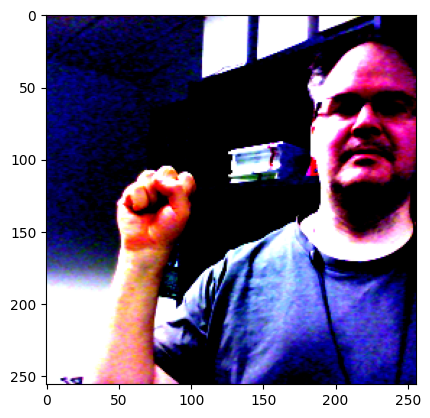

In [9]:
import matplotlib.pyplot as plt

plt.imshow(train_ds[0][0].permute(1, 2, 0).numpy())

In [10]:
""" DINO model architecture """
model.blocks

ModuleList(
  (0-11): 12 x EvaBlock(
    (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (attn): EvaAttention(
      (qkv): Linear(in_features=384, out_features=1152, bias=False)
      (q_norm): Identity()
      (k_norm): Identity()
      (attn_drop): Dropout(p=0.0, inplace=False)
      (norm): Identity()
      (proj): Linear(in_features=384, out_features=384, bias=True)
      (proj_drop): Dropout(p=0.0, inplace=False)
    )
    (drop_path1): Identity()
    (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (mlp): Mlp(
      (fc1): Linear(in_features=384, out_features=1536, bias=True)
      (act): GELU(approximate='none')
      (drop1): Dropout(p=0.0, inplace=False)
      (norm): Identity()
      (fc2): Linear(in_features=1536, out_features=384, bias=True)
      (drop2): Dropout(p=0.0, inplace=False)
    )
    (drop_path2): Identity()
  )
)

In [13]:
"""Utility functions"""
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from torch.optim import AdamW
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import timm


import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score


# Optimizer / Scheduler
def param_groups(model, weight_decay=0.05):
    """ Add weight decay on non-bias or non-LayerNorm, BatchNorm weights"""
    decay, no_decay = [], []
    for n, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if p.ndim == 1 or n.endswith(".bias"):  # bias or LayerNorm/BatchNorm weights
            no_decay.append(p)
        else:
            decay.append(p)
    return [
        {"params": decay, "weight_decay": weight_decay},
        {"params": no_decay, "weight_decay": 0.0},
    ]


# Training / Evaluation loops
def train_one_epoch(model, loader, optimizer, scaler, epoch, max_norm=1.0):
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0

    pbar = tqdm(loader, desc=f"Train {epoch}", leave=False)
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # Mixed precision training
        with autocast('cuda'):
            logits = model(imgs)
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()

        # Gradient clipping
        scaler.unscale_(optimizer)
        if max_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()

        preds = logits.argmax(1)
        running_loss += loss.item() * imgs.size(0)
        running_correct += (preds == labels).sum().item()
        total += imgs.size(0)
        pbar.set_postfix(loss=running_loss/total, acc=running_correct/total)

    return running_loss / total, running_correct / total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    running_loss, running_correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        with autocast('cuda'):
            logits = model(imgs)
            loss = criterion(logits, labels)
        preds = logits.argmax(1)
        running_loss += loss.item() * imgs.size(0)
        running_correct += (preds == labels).sum().item()
        total += imgs.size(0)
    return running_loss / total, running_correct / total

def eval_on_test(model, test_loader):
  # Evaluation on the test set
  model.eval()
  total_loss = 0.0
  total_correct = 0
  total = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for imgs, labels in test_loader:
          imgs, labels = imgs.to(device), labels.to(device)
          logits = model(imgs)
          preds = logits.argmax(1)

          total_correct += (preds == labels).sum().item()
          total += imgs.size(0)

          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  accuracy = total_correct / total
  precision = precision_score(all_labels, all_preds, average='macro')
  recall = recall_score(all_labels, all_preds, average='macro')
  f1 = f1_score(all_labels, all_preds, average='macro')

  print(f"Test accuracy: {accuracy:.4f}")
  print(f"Precision (macro): {precision:.4f}")
  print(f"Recall (macro): {recall:.4f}")
  print(f"F1-score (macro): {f1:.4f}")

def visualize_attention_map(img, model):
  """Visualize attention map"""
  x = img.unsqueeze(0) # [1, 3, H, W]
  x = x.to(device)

  IMG_SIZE = x.shape[-1] # H = W
  patch = model.patch_embed.patch_size[0]

  # ---- Run through all but the last block; capture tokens pre-last-attn ----
  with torch.no_grad():
      # Patch embed + pos embed (+ optional pre-norm) like timm's forward_features
      x_tok = model.patch_embed(x)              # [B, Np, C]   (no cls yet)
      x_tok = model._pos_embed(x_tok)           # adds cls token & pos emb if present

      # Check if x_tok is a tuple and extract the tensor if it is
      if isinstance(x_tok, tuple):
          x_tok = x_tok[0]
      if hasattr(model, "pos_drop"):
          x_tok = model.pos_drop(x_tok)
      if hasattr(model, "norm_pre") and model.norm_pre is not None:
          x_tok = model.norm_pre(x_tok)

      # Forward through blocks except the last
      for blk in model.blocks[:-1]:
          x_tok = blk(x_tok)

      last_blk = model.blocks[-1]

      # ---- Compute attention of the last block explicitly ----
      # In a ViT block: y = x + Attn(LN1(x)), so the attention takes LN1(x) as input
      x_norm = last_blk.norm1(x_tok)

      # QKV projection
      B, N, C = x_norm.shape
      qkv = last_blk.attn.qkv(x_norm)  # [B, N, 3*C]
      num_heads = last_blk.attn.num_heads
      head_dim = C // num_heads
      scale = 1.0 / math.sqrt(head_dim)

      qkv = qkv.reshape(B, N, 3, num_heads, head_dim).permute(2, 0, 3, 1, 4)   # [3,B,H,N,D]
      q, k, v = qkv[0], qkv[1], qkv[2]                                         # each [B,H,N,D]

      attn = (q * scale) @ k.transpose(-2, -1)                                 # [B,H,N,N]
      attn = attn.softmax(dim=-1)                                              # prob over keys

      # ---- Reshape to patch grid and upsample to image size ----
      H_p = W_p = IMG_SIZE // patch                 # e.g., 32x32 for 512 input
      Np = H_p * W_p

      # ---- CLS-to-patches attention map (average over heads) ----
      # CLS token is at index 0; keep only patch tokens by slicing from (N - Np) onwards
      attn_cls = attn[:, :, 0, (N - Np):]                                      # [B, H, Np]
      attn_map = attn_cls.max(1).values

      # robust: patches are the *last* Np tokens in the sequence
      attn_map = attn_map.reshape(B, 1, H_p, W_p) # [B,1,H_p,W_p]
      attn_map = F.interpolate(attn_map, size=(IMG_SIZE, IMG_SIZE), mode="bicubic", align_corners=False)
      attn_map = attn_map[0,0] # [H, W]
      # Normalize for visualization
      attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-6)

  # ---- Plot overlay ----
  plt.figure(figsize=(8,8))
  img_np = x[0].cpu().permute(1, 2, 0).numpy()
  plt.imshow(img_np)
  plt.imshow(attn_map.cpu(), cmap='jet', alpha=0.6)
  plt.axis('off')
  plt.tight_layout()
  plt.show()



DINO Fine-tune with last 1 blocks unfrozen


Epoch 01: train_loss=1.7934 train_acc=0.4238 | val_loss=0.8313 val_acc=0.7775


Epoch 02: train_loss=0.3298 train_acc=0.9500 | val_loss=0.2044 val_acc=0.9750


Epoch 03: train_loss=0.0611 train_acc=0.9950 | val_loss=0.1186 val_acc=0.9725


Epoch 04: train_loss=0.0243 train_acc=0.9981 | val_loss=0.1133 val_acc=0.9675


Epoch 05: train_loss=0.0111 train_acc=1.0000 | val_loss=0.0744 val_acc=0.9800
Saved best model with val_acc=0.9800 to vit_dinov3_best.pt
Test accuracy: 0.9350
Precision (macro): 0.9358
Recall (macro): 0.9350
F1-score (macro): 0.9347


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
vit_base_patch16_dinov3.lvd1689m
FLOPs: 179.76G
Params: 21.56M


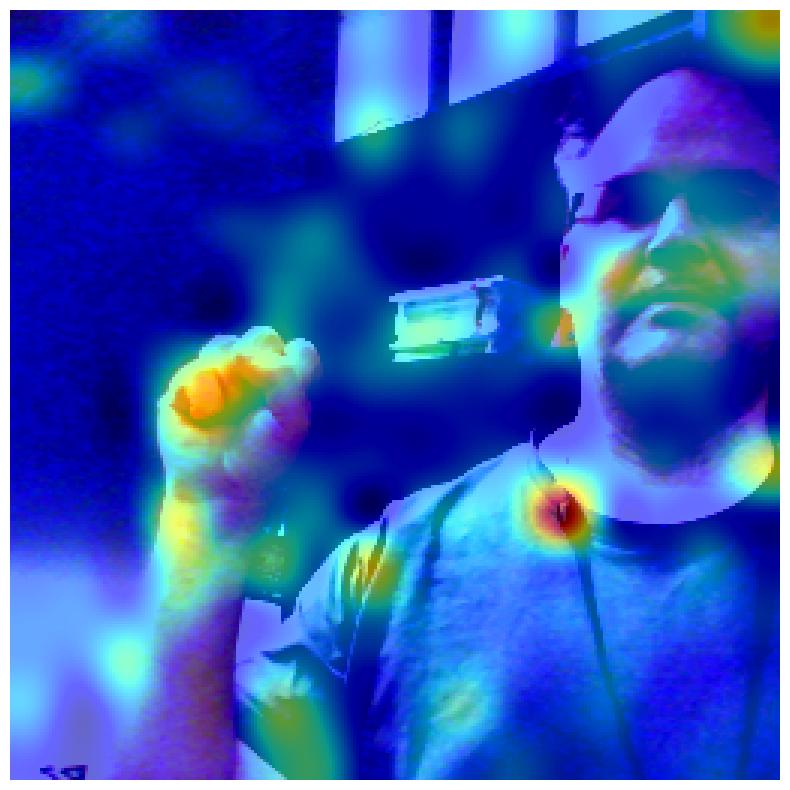

DINO Fine-tune with last 2 blocks unfrozen


Epoch 01: train_loss=1.2987 train_acc=0.5781 | val_loss=0.4090 val_acc=0.8850


Epoch 02: train_loss=0.1271 train_acc=0.9794 | val_loss=0.0727 val_acc=0.9950


Epoch 03: train_loss=0.0163 train_acc=1.0000 | val_loss=0.0459 val_acc=0.9925


Epoch 04: train_loss=0.0062 train_acc=1.0000 | val_loss=0.0227 val_acc=1.0000


Epoch 05: train_loss=0.0037 train_acc=1.0000 | val_loss=0.0246 val_acc=0.9950
Saved best model with val_acc=1.0000 to vit_dinov3_best.pt
Test accuracy: 0.9550
Precision (macro): 0.9559
Recall (macro): 0.9550
F1-score (macro): 0.9549


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
vit_base_patch16_dinov3.lvd1689m
FLOPs: 179.76G
Params: 21.56M


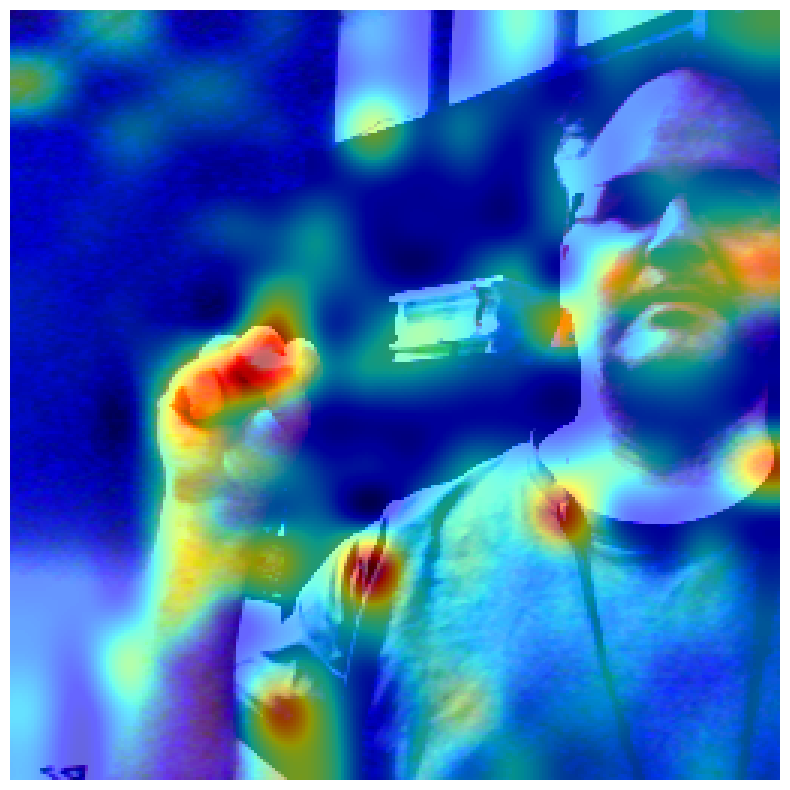

DINO Fine-tune with last 3 blocks unfrozen


Epoch 01: train_loss=1.0571 train_acc=0.6519 | val_loss=0.1915 val_acc=0.9675


Epoch 02: train_loss=0.0762 train_acc=0.9862 | val_loss=0.0653 val_acc=0.9875


Epoch 03: train_loss=0.0176 train_acc=0.9988 | val_loss=0.0350 val_acc=0.9875


Epoch 04: train_loss=0.0059 train_acc=0.9994 | val_loss=0.0217 val_acc=0.9950


Epoch 05: train_loss=0.0039 train_acc=1.0000 | val_loss=0.0135 val_acc=0.9950
Saved best model with val_acc=0.9950 to vit_dinov3_best.pt
Test accuracy: 0.9490
Precision (macro): 0.9527
Recall (macro): 0.9490
F1-score (macro): 0.9493


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
vit_base_patch16_dinov3.lvd1689m
FLOPs: 179.76G
Params: 21.56M


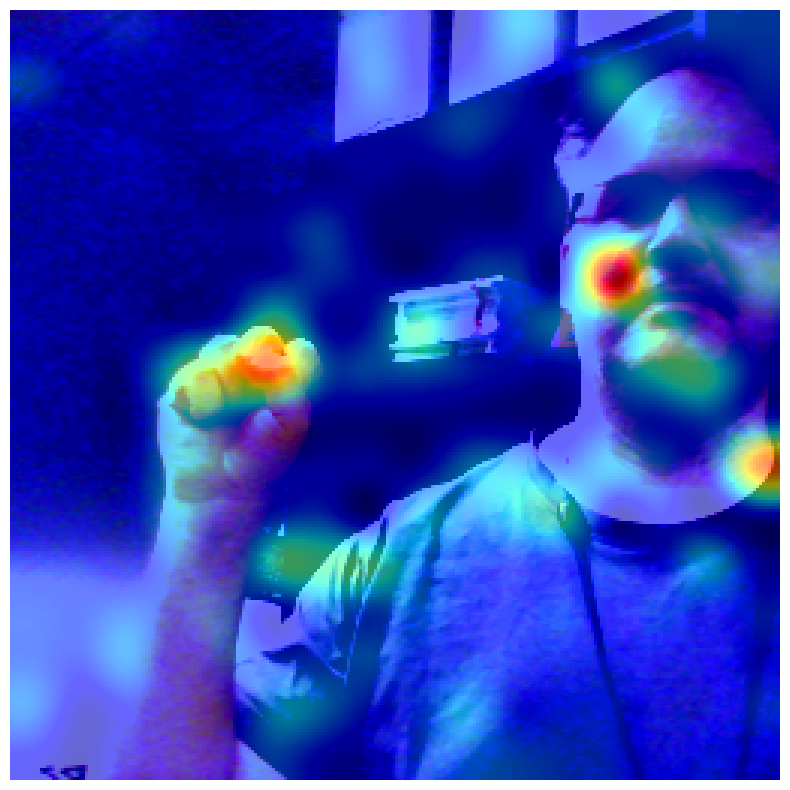

DINO Fine-tune with last 4 blocks unfrozen


Epoch 01: train_loss=0.8504 train_acc=0.7544 | val_loss=0.0715 val_acc=0.9975


Epoch 02: train_loss=0.0293 train_acc=0.9962 | val_loss=0.0324 val_acc=0.9875


Epoch 03: train_loss=0.0403 train_acc=0.9906 | val_loss=0.0445 val_acc=0.9875


Epoch 04: train_loss=0.0169 train_acc=0.9944 | val_loss=0.1125 val_acc=0.9675


Epoch 05: train_loss=0.0067 train_acc=0.9994 | val_loss=0.0279 val_acc=0.9925
Saved best model with val_acc=0.9975 to vit_dinov3_best.pt
Test accuracy: 0.9370
Precision (macro): 0.9404
Recall (macro): 0.9370
F1-score (macro): 0.9365


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
vit_base_patch16_dinov3.lvd1689m
FLOPs: 179.76G
Params: 21.56M


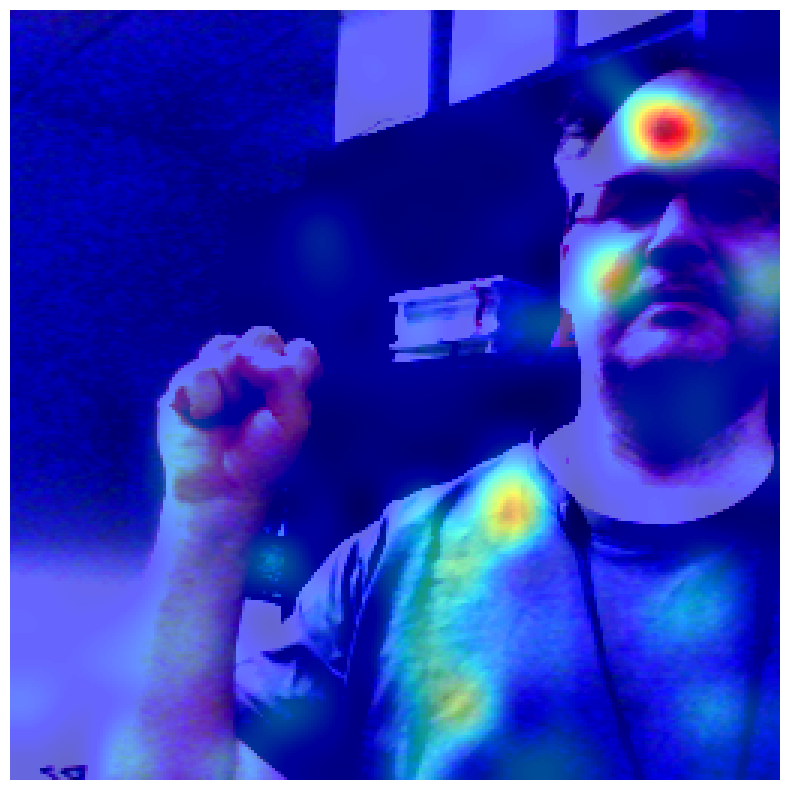

DINO Fine-tune with last 5 blocks unfrozen


Epoch 01: train_loss=0.7522 train_acc=0.7944 | val_loss=0.1178 val_acc=0.9625


Epoch 02: train_loss=0.0521 train_acc=0.9875 | val_loss=0.0511 val_acc=0.9825


Epoch 03: train_loss=0.0099 train_acc=0.9975 | val_loss=0.0272 val_acc=0.9925


Epoch 04: train_loss=0.0077 train_acc=0.9988 | val_loss=0.0126 val_acc=0.9975


Epoch 05: train_loss=0.0022 train_acc=1.0000 | val_loss=0.0038 val_acc=1.0000
Saved best model with val_acc=1.0000 to vit_dinov3_best.pt
Test accuracy: 0.9470
Precision (macro): 0.9507
Recall (macro): 0.9470
F1-score (macro): 0.9475


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
vit_base_patch16_dinov3.lvd1689m
FLOPs: 179.76G
Params: 21.56M


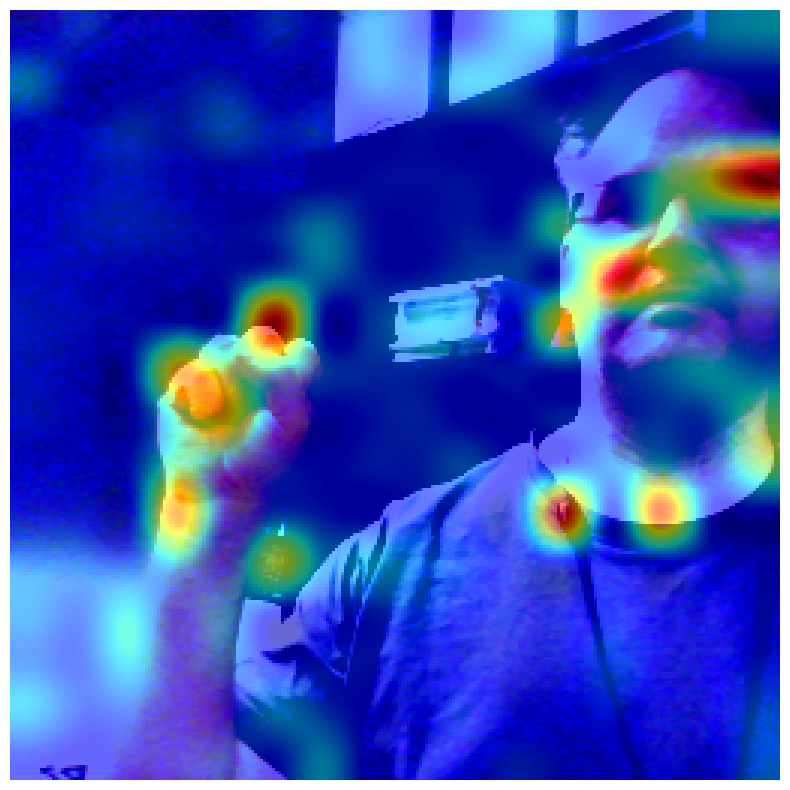

In [20]:
"""DINO - unfreeze last K blocks"""
num_classes = 10

for K in range(1, 6):
  model = timm.create_model(
      'vit_small_patch16_dinov3',
      pretrained=True,
  )

  # Replace classifier head
  model.reset_classifier(num_classes=num_classes)
  model = model.to(device)

  # Unfreeze the last K blocks
  for p in model.parameters():
      p.requires_grad = False

  for block in model.blocks[-K:]:
      for p in block.parameters():
          p.requires_grad = True

  for p in model.get_classifier().parameters():
      p.requires_grad = True

  lr = 5e-4
  optimizer = AdamW(param_groups(model), lr=lr, betas=(0.9, 0.999))
  criterion = nn.CrossEntropyLoss()

  # LR scheduling
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

  # Gradient Scaling
  scaler = GradScaler()

  # Training
  epochs = 5
  best_acc = 0.0
  best_state = None

  print(f"DINO Fine-tune with last {K} blocks unfrozen")
  for epoch in range(1, epochs + 1):
      train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scaler, epoch)
      val_loss, val_acc = evaluate(model, val_loader)
      scheduler.step()

      print(f"Epoch {epoch:02d}: "
            f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
            f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

      if val_acc > best_acc:
          best_acc = val_acc
          best_state = {k: v.cpu() for k, v in model.state_dict().items()}

  if best_state is not None:
    best_name = f"{dino_model_name}_{K}_unfrozen_best.pt"
    torch.save(best_state, f"./checkpoints/{best_name}")
    print(f"Saved best model with val_acc={best_acc:.4f} to vit_dinov3_best.pt")

  eval_on_test(model, test_loader)

  # Flop & model size
  from thop import profile
  dummy_input = next(iter(test_loader))[0]
  dummy_input = dummy_input.to(device)
  flops, params = profile(model, inputs=(dummy_input,))

  print("vit_base_patch16_dinov3.lvd1689m")
  print(f"FLOPs: {flops / 1e9:.2f}G")
  print(f"Params: {params / 1e6:.2f}M")
  visualize_attention_map(train_ds[0][0], model)


vit_small_patch16_dinov3 with last 6 blocks unfrozen


Epoch 01: train_loss=0.7552 train_acc=0.7806 | val_loss=0.1174 val_acc=0.9600


Epoch 02: train_loss=0.0804 train_acc=0.9788 | val_loss=0.0430 val_acc=0.9850


Epoch 03: train_loss=0.0175 train_acc=0.9944 | val_loss=0.0627 val_acc=0.9750


Epoch 04: train_loss=0.0340 train_acc=0.9900 | val_loss=0.0290 val_acc=0.9925


Epoch 05: train_loss=0.0142 train_acc=0.9975 | val_loss=0.0039 val_acc=1.0000
Test accuracy: 0.9160
Precision (macro): 0.9283
Recall (macro): 0.9160
F1-score (macro): 0.9178




[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
vit_base_patch16_dinov3.lvd1689m
FLOPs: 179.76G
Params: 21.56M


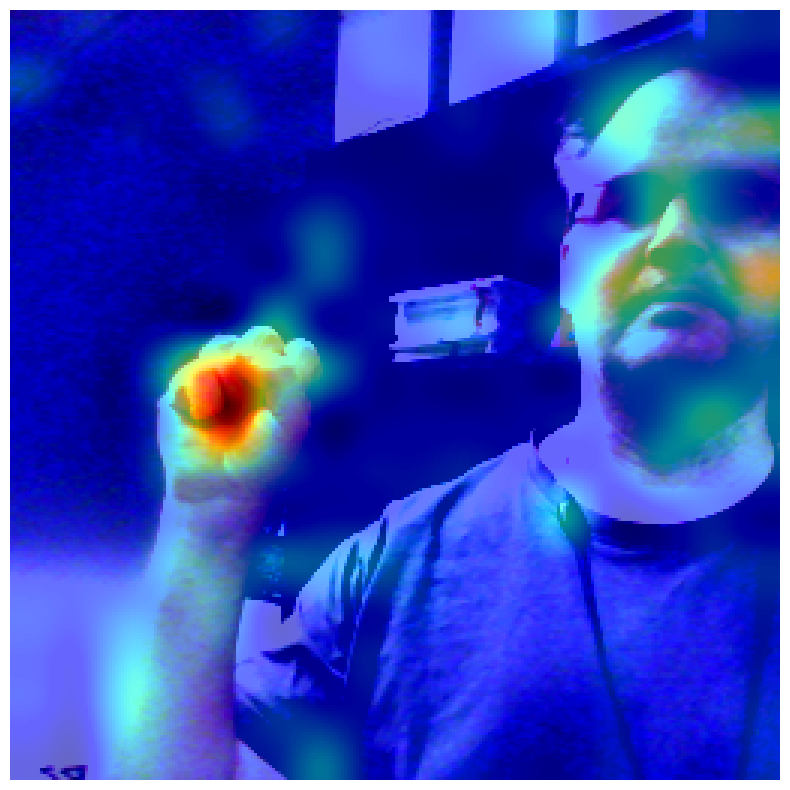

vit_small_patch16_dinov3 with last 7 blocks unfrozen


Epoch 01: train_loss=0.8160 train_acc=0.7762 | val_loss=0.0752 val_acc=0.9875


Epoch 02: train_loss=0.0558 train_acc=0.9881 | val_loss=0.0558 val_acc=0.9850


Epoch 03: train_loss=0.0390 train_acc=0.9906 | val_loss=0.0785 val_acc=0.9750


Epoch 04: train_loss=0.0375 train_acc=0.9925 | val_loss=0.0298 val_acc=0.9950


Epoch 05: train_loss=0.0309 train_acc=0.9938 | val_loss=0.0426 val_acc=0.9850
Test accuracy: 0.9000
Precision (macro): 0.9071
Recall (macro): 0.9000
F1-score (macro): 0.9003




[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
vit_base_patch16_dinov3.lvd1689m
FLOPs: 179.76G
Params: 21.56M


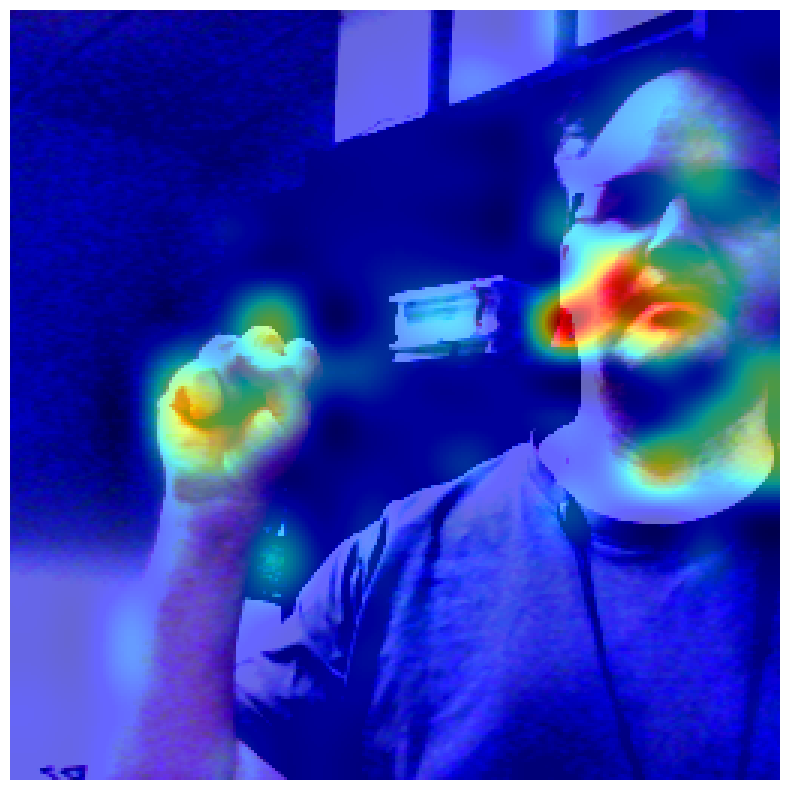

vit_small_patch16_dinov3 with last 8 blocks unfrozen


Epoch 01: train_loss=0.8768 train_acc=0.7344 | val_loss=0.0674 val_acc=0.9975


Epoch 02: train_loss=0.0572 train_acc=0.9856 | val_loss=0.0283 val_acc=0.9925


Epoch 03: train_loss=0.0296 train_acc=0.9956 | val_loss=0.0344 val_acc=0.9925


Epoch 04: train_loss=0.0459 train_acc=0.9850 | val_loss=0.0306 val_acc=0.9900


Epoch 05: train_loss=0.0458 train_acc=0.9875 | val_loss=0.0425 val_acc=0.9875
Test accuracy: 0.8810
Precision (macro): 0.8892
Recall (macro): 0.8810
F1-score (macro): 0.8808




[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
vit_base_patch16_dinov3.lvd1689m
FLOPs: 179.76G
Params: 21.56M


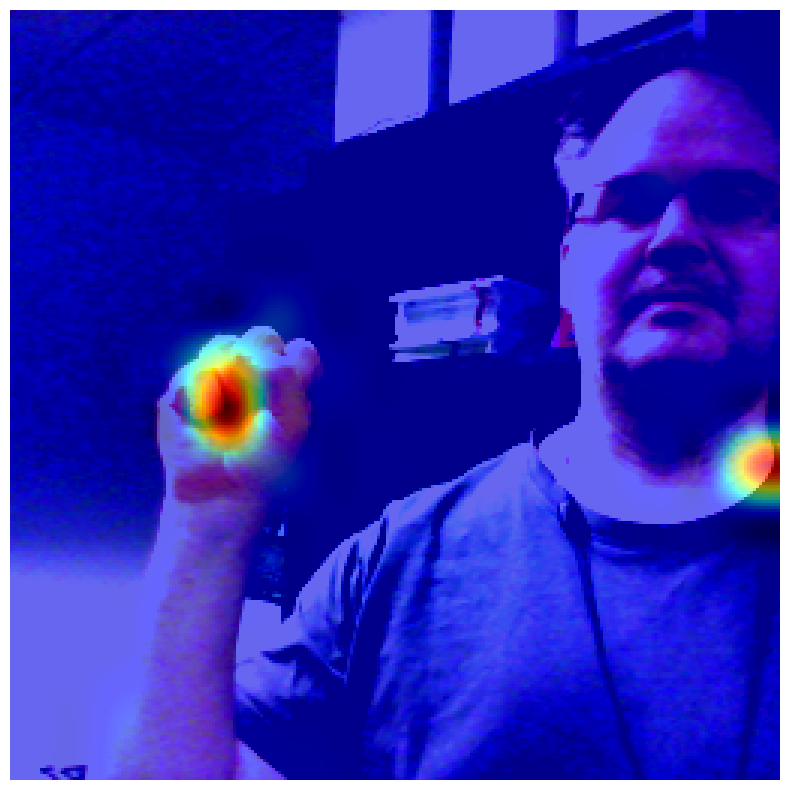

vit_small_patch16_dinov3 with last 9 blocks unfrozen


Epoch 01: train_loss=0.7418 train_acc=0.8044 | val_loss=0.0743 val_acc=0.9875


Epoch 02: train_loss=0.0599 train_acc=0.9850 | val_loss=0.0568 val_acc=0.9850


Epoch 03: train_loss=0.0355 train_acc=0.9925 | val_loss=0.0954 val_acc=0.9700


Epoch 04: train_loss=0.0398 train_acc=0.9869 | val_loss=0.0412 val_acc=0.9850


Epoch 05: train_loss=0.0365 train_acc=0.9862 | val_loss=0.1137 val_acc=0.9750
Test accuracy: 0.8850
Precision (macro): 0.8924
Recall (macro): 0.8850
F1-score (macro): 0.8846




[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
vit_base_patch16_dinov3.lvd1689m
FLOPs: 179.76G
Params: 21.56M


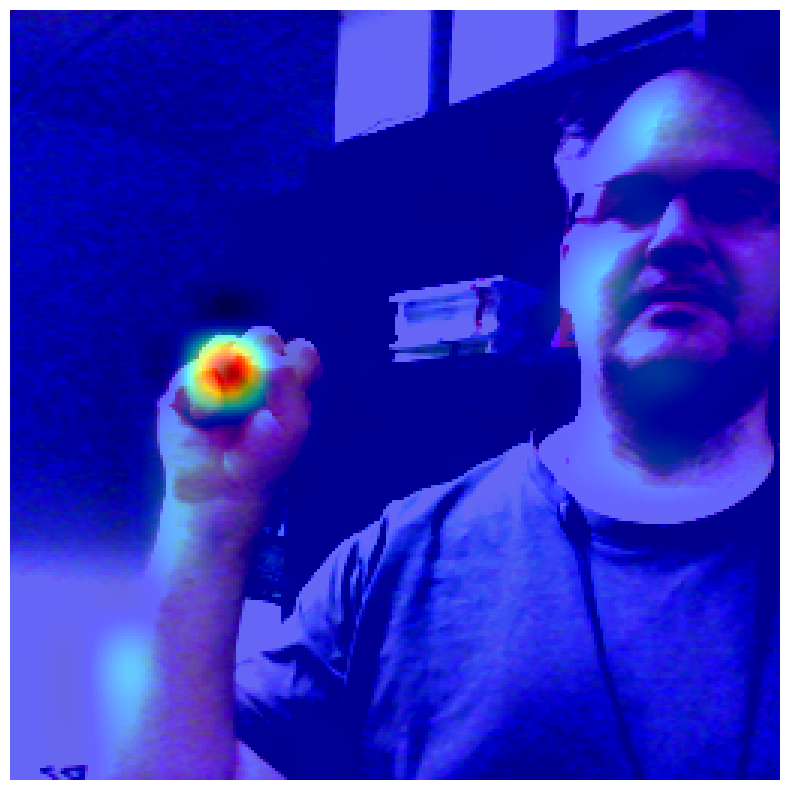

vit_small_patch16_dinov3 with last 10 blocks unfrozen


Epoch 01: train_loss=0.7976 train_acc=0.7612 | val_loss=0.1157 val_acc=0.9600


Epoch 02: train_loss=0.0664 train_acc=0.9856 | val_loss=0.0981 val_acc=0.9675


Epoch 03: train_loss=0.0582 train_acc=0.9831 | val_loss=0.3004 val_acc=0.9275


Epoch 04: train_loss=0.0366 train_acc=0.9938 | val_loss=0.1428 val_acc=0.9550


Epoch 05: train_loss=0.0078 train_acc=0.9988 | val_loss=0.1216 val_acc=0.9550
Test accuracy: 0.8590
Precision (macro): 0.8758
Recall (macro): 0.8590
F1-score (macro): 0.8570




[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
vit_base_patch16_dinov3.lvd1689m
FLOPs: 179.76G
Params: 21.56M


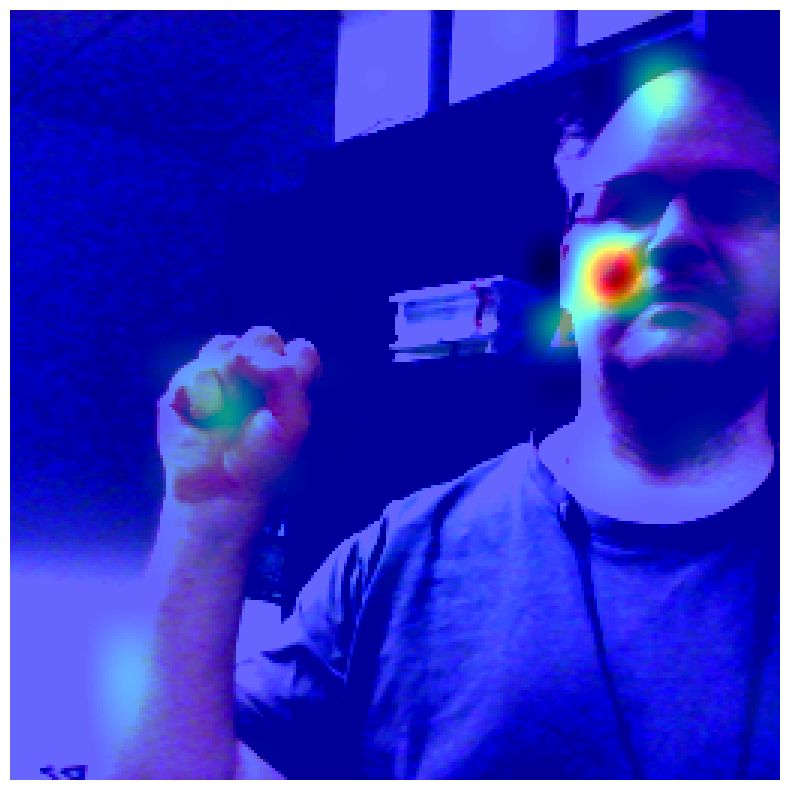

vit_small_patch16_dinov3 with last 11 blocks unfrozen


Epoch 01: train_loss=0.8392 train_acc=0.7456 | val_loss=0.1236 val_acc=0.9750


Epoch 02: train_loss=0.0671 train_acc=0.9825 | val_loss=0.1212 val_acc=0.9575


Epoch 03: train_loss=0.0649 train_acc=0.9806 | val_loss=0.1297 val_acc=0.9575


Epoch 04: train_loss=0.0392 train_acc=0.9894 | val_loss=0.1408 val_acc=0.9600


Epoch 05: train_loss=0.0216 train_acc=0.9931 | val_loss=0.0406 val_acc=0.9875
Test accuracy: 0.8590
Precision (macro): 0.8705
Recall (macro): 0.8590
F1-score (macro): 0.8610




[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
vit_base_patch16_dinov3.lvd1689m
FLOPs: 179.76G
Params: 21.56M


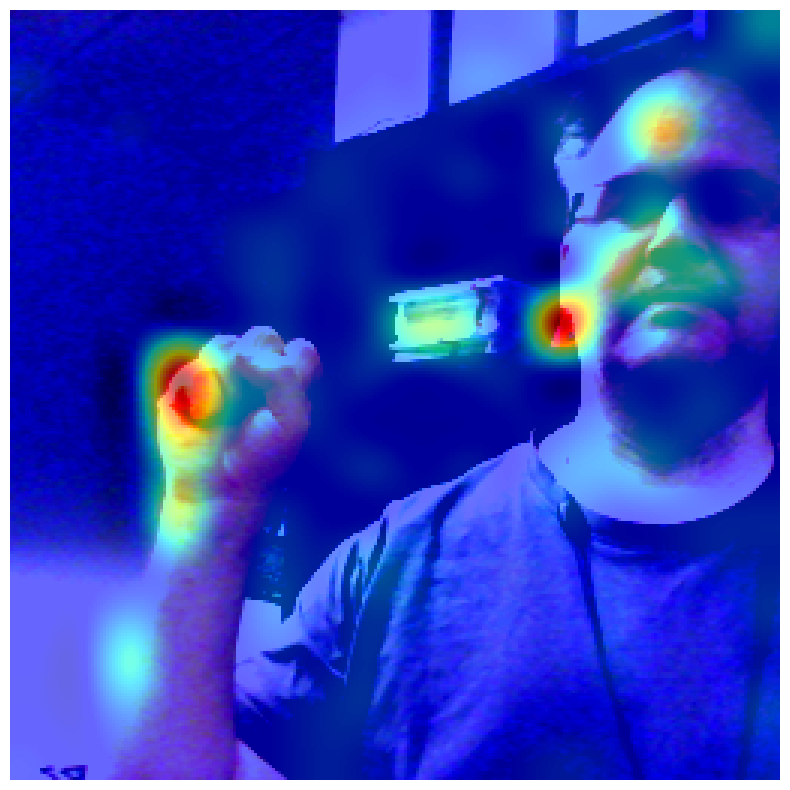

vit_small_patch16_dinov3 with last 12 blocks unfrozen


Epoch 01: train_loss=0.8012 train_acc=0.7606 | val_loss=0.0870 val_acc=0.9875


Epoch 02: train_loss=0.0604 train_acc=0.9844 | val_loss=0.2415 val_acc=0.9525


Epoch 03: train_loss=0.0427 train_acc=0.9894 | val_loss=0.0763 val_acc=0.9775


Epoch 04: train_loss=0.0358 train_acc=0.9888 | val_loss=0.1277 val_acc=0.9750


Epoch 05: train_loss=0.0391 train_acc=0.9900 | val_loss=0.1949 val_acc=0.9475
Test accuracy: 0.8240
Precision (macro): 0.8432
Recall (macro): 0.8240
F1-score (macro): 0.8267




[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
vit_base_patch16_dinov3.lvd1689m
FLOPs: 179.76G
Params: 21.56M


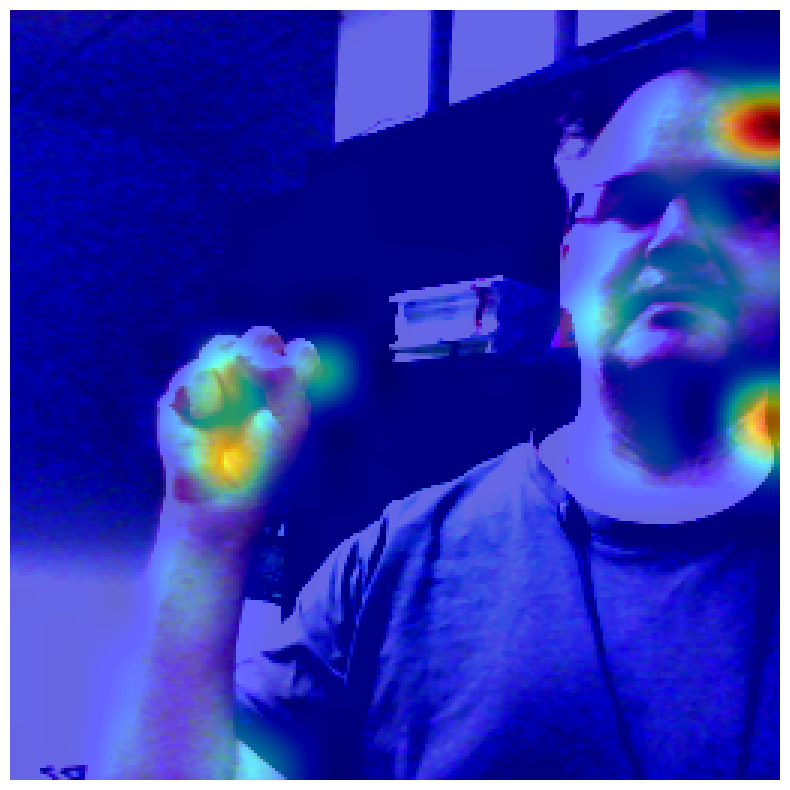

In [22]:
"""DINO - unfreeze last K blocks"""
num_classes = 10

for K in range(6, 13):
  model = timm.create_model(
      'vit_small_patch16_dinov3',
      pretrained=True,
  )

  # Replace classifier head
  model.reset_classifier(num_classes=num_classes)
  model = model.to(device)

  # Unfreeze the last K blocks
  for p in model.parameters():
      p.requires_grad = False

  for block in model.blocks[-K:]:
      for p in block.parameters():
          p.requires_grad = True

  for p in model.get_classifier().parameters():
      p.requires_grad = True

  lr = 5e-4
  optimizer = AdamW(param_groups(model), lr=lr, betas=(0.9, 0.999))
  criterion = nn.CrossEntropyLoss()

  # LR scheduling
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

  # Gradient Scaling
  scaler = GradScaler()

  # Training
  epochs = 5
  best_acc = 0.0
  best_state = None

  print(f"{dino_model_name} with last {K} blocks unfrozen")
  for epoch in range(1, epochs + 1):
      train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scaler, epoch)
      val_loss, val_acc = evaluate(model, val_loader)
      scheduler.step()

      print(f"Epoch {epoch:02d}: "
            f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
            f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

      if val_acc > best_acc:
          best_acc = val_acc
          best_state = {k: v.cpu() for k, v in model.state_dict().items()}

  if best_state is not None:
    best_name = f"{dino_model_name}_{K}_unfrozen_best.pt"
    torch.save(best_state, f"./checkpoints/{best_name}")

  eval_on_test(model, test_loader)
  print('\n')

  # Flop & model size
  from thop import profile
  dummy_input = next(iter(test_loader))[0]
  dummy_input = dummy_input.to(device)
  flops, params = profile(model, inputs=(dummy_input,))

  print("vit_base_patch16_dinov3.lvd1689m")
  print(f"FLOPs: {flops / 1e9:.2f}G")
  print(f"Params: {params / 1e6:.2f}M")
  visualize_attention_map(train_ds[0][0], model)


In [27]:
"""Same ViT model supervised pretrained"""

vit_model = timm.create_model('vit_small_patch16_224', pretrained=True)

# Replace classifier head
vit_model.reset_classifier(num_classes=num_classes)
vit_model = vit_model.to(device)

# Unfreeze the last K blocks
for p in vit_model.parameters():
    p.requires_grad = False

for block in vit_model.blocks[-K:]:
    for p in block.parameters():
        p.requires_grad = True

for p in vit_model.get_classifier().parameters():
    p.requires_grad = True

data_config = timm.data.resolve_model_data_config(vit_model)
transform = timm.data.create_transform(**data_config, is_training=False)

batch_size = 32
num_workers = 4
use_bbox = False

train_ds = OuhandsDS(split='train',
                     transform=transform,
                     use_bounding_box=use_bbox,
                     crop_to_bbox=use_bbox)
val_ds = OuhandsDS(split='validation',
                   transform=transform,
                   use_bounding_box=use_bbox,
                   crop_to_bbox=use_bbox)
test_ds = OuhandsDS(split='test',
                    transform=transform,
                    use_bounding_box=use_bbox,
                    crop_to_bbox=use_bbox)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True
                          ,  num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False
                        , num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False
                          , num_workers=num_workers, pin_memory=True)


# Same everything
lr = 5e-4
optimizer = AdamW(param_groups(vit_model), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

# LR scheduling
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Gradient Scaling
scaler = GradScaler()

# Training
epochs = 10
best_acc = 0.0
best_state = None

print(f'Training ViT model with the same setting')
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_one_epoch(vit_model, train_loader, optimizer, scaler, epoch)
    val_loss, val_acc = evaluate(vit_model, val_loader)
    scheduler.step()

    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

Loaded 1600 samples for train split
Class distribution: {'A': 160, 'B': 160, 'C': 160, 'D': 160, 'E': 160, 'F': 160, 'H': 160, 'I': 160, 'J': 160, 'K': 160}
Loaded 400 samples for validation split
Class distribution: {'A': 40, 'B': 40, 'C': 40, 'D': 40, 'E': 40, 'F': 40, 'H': 40, 'I': 40, 'J': 40, 'K': 40}
Loaded 1000 samples for test split
Class distribution: {'A': 100, 'B': 100, 'C': 100, 'D': 100, 'E': 100, 'F': 100, 'H': 100, 'I': 100, 'J': 100, 'K': 100}
Training ViT model with the same setting


Epoch 01: train_loss=1.3392 train_acc=0.5556 | val_loss=0.8935 val_acc=0.6590


Epoch 02: train_loss=0.2221 train_acc=0.9213 | val_loss=1.0087 val_acc=0.7100


Epoch 03: train_loss=0.1385 train_acc=0.9556 | val_loss=0.9178 val_acc=0.7560


Epoch 04: train_loss=0.0736 train_acc=0.9769 | val_loss=1.0342 val_acc=0.7550


Epoch 05: train_loss=0.0257 train_acc=0.9919 | val_loss=1.0911 val_acc=0.7450


Epoch 06: train_loss=0.0289 train_acc=0.9906 | val_loss=1.0506 val_acc=0.7770


Epoch 07: train_loss=0.0153 train_acc=0.9925 | val_loss=1.2553 val_acc=0.7800


Epoch 08: train_loss=0.0295 train_acc=0.9925 | val_loss=1.2985 val_acc=0.7470


Epoch 09: train_loss=0.0101 train_acc=0.9969 | val_loss=1.4128 val_acc=0.7690


Epoch 10: train_loss=0.0107 train_acc=0.9962 | val_loss=1.4011 val_acc=0.7810


In [28]:
print("vit_base_patch16_224")
eval_on_test(vit_model, test_loader)

vit_base_patch16_224
Test accuracy: 0.7810
Precision (macro): 0.8072
Recall (macro): 0.7810
F1-score (macro): 0.7754


In [29]:
! pip install thop

In [30]:
dummy_input = next(iter(test_loader))[0]
dummy_input = dummy_input.to(device)
flops, params = profile(vit_model, inputs=(dummy_input,))

print("vit_base_patch16_224")
print(f"FLOPs: {flops / 1e9:.2f}G")
print(f"Params: {params / 1e6:.2f}M")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
vit_base_patch16_224
FLOPs: 135.71G
Params: 21.57M
